In [9]:
import io
import glob
import os

from sys import platform
# print(platform)
if platform == "linux" or platform == "linux2":
	loc = "home"
elif platform == "darwin":
	loc = "Users"
else:
	print("Unknown platform.")
	
# from PIL import Image, ImageOps
from stl import mesh # pip install numpy-stl
# import xml.etree.cElementTree as ETree
# import zipfile
import numpy as np
import math
import multiprocessing as mp
import matplotlib.pyplot as plt
import string
import random

class PolygonRepair():
	def __init__(self, segments, dimensions):
		# Maps endpoints to the polygon they form
		self.loops = []
		# Populate initially
		self.polylines = []
		self.original_segments = segments
		self.dimensions = dimensions
		self.collapse_segments()

	def collapse_segments(self):
		self.loops = []
		self.polylines = []
		for polyline in self.find_polylines(self.original_segments):
			if polyline[0] == polyline[-1]:
				self.loops.append(polyline)
			else:
				self.polylines.append(polyline)

	def repair_all(self):
		while self.polylines:
			self.repair_polyline()
			old_seg_length = len(self.polylines)
			self.collapse_segments()
			assert old_seg_length - 1 == len(self.polylines)
		assert len(self.polylines) == 0

	def repair_polyline(self):
		# Search starts at the end of an arbitrary polyline
		search_start = self.polylines[0][-1]
		# Search will conclude when it finds the beginning of any polyline (including itself)
		search_ends = [polyline[0] for polyline in self.polylines]
		polyline_endpoints = [(polyline[0], polyline[-1]) for polyline in self.polylines]
		max_iterations = self.dimensions[0] + self.dimensions[1]
		end = self.winding_number_search(search_start, search_ends, polyline_endpoints, max_iterations)
		self.original_segments.append((search_start, end))

	def find_polylines(self, segments):
		polylines = []
		segment_forward_dict = {}
		segment_backward_dict = {}

		for segment in segments:
			start, end = segment
			if start not in segment_forward_dict:
				segment_forward_dict[start] = []
			segment_forward_dict[start].append(end)
			if end not in segment_backward_dict:
				segment_backward_dict[end] = []
			segment_backward_dict[end].append(start)

		while len(segment_forward_dict) > 0:
			start = list(segment_forward_dict.keys())[0]
			polyline = [start]

			while True:
				if start not in segment_forward_dict:
					break
				next_points = segment_forward_dict[start]
				end = next_points[0]

				segment_forward_dict[start].remove(end)
				if len(segment_forward_dict[start]) == 0:
					del segment_forward_dict[start]
				segment_backward_dict[end].remove(start)
				if len(segment_backward_dict[end]) == 0:
					del segment_backward_dict[end]
				polyline.append(end)
				start = end

			start = polyline[0]
			while True:
				if start not in segment_backward_dict:
					break
				next_points = segment_backward_dict[start]
				end = next_points[0]

				segment_backward_dict[start].remove(end)
				if len(segment_backward_dict[start]) == 0:
					del segment_backward_dict[start]
				segment_forward_dict[end].remove(start)
				if len(segment_forward_dict[end]) == 0:
					del segment_forward_dict[end]
				polyline.insert(0, end)
				start = end
			polylines.append(polyline)

		return polylines

	def find_polyline_endpoints(self, segs):
		start_to_end = dict()
		end_to_start = dict()

		for start, end in segs:
			actual_start = end_to_start.get(start, start)
			actual_end = start_to_end.get(end, end)

			if actual_start == actual_end:
				del end_to_start[actual_start]
				del start_to_end[actual_start]
				continue

			start_to_end[actual_start] = actual_end
			end_to_start[actual_end] = actual_start

			if start in end_to_start:
				del end_to_start[start]
			if end in start_to_end:
				del start_to_end[end]

		return start_to_end

	def atan_sum(self, f1, f2):
		x1, y1 = f1
		x2, y2 = f2
		return (x1 * x2 - y1 * y2, y1 * x2 + x1 * y2)

	def atan_diff(self, f1, f2):
		x1, y1 = f1
		x2, y2 = f2
		return (x1 * x2 + y1 * y2, y1 * x2 - x1 * y2)

	def subtract(self, s1, s2):
		return (s1[0] - s2[0], s1[1] - s2[1])

	def add(self, s1, s2):
		return (s1[0] + s2[0], s1[1] + s2[1])

	def winding_contour_pole(self, pos, pt, repel):
		x, y = self.subtract(pos, pt)
		dist2 = (x ** 2 + y ** 2)
		cx = x / dist2
		cy = y / dist2
		if repel:
			return (cx, cy)
		else:
			return (-cx, -cy)

	def normalize(self, pt):
		x, y = pt
		dist = math.sqrt(x ** 2 + y ** 2)
		return (x / dist, y / dist)

	def distance_squared(self, p1, p2):
		x1, y1 = p1
		x2, y2 = p2
		return (y2 - y1) ** 2 + (x2 - x1) ** 2

	def initial_direction(self, pt, polyline_endpoints):
		accum = (1, 0)
		for start, end in polyline_endpoints:
			if start != pt:
				accum = self.atan_sum(accum, self.subtract(start, pt))
			if end != pt:
				accum = self.atan_diff(accum, self.subtract(end, pt))
			accum = self.normalize(accum)
		return np.array(accum)

	def winding_contour(self, pos, segs):
		accum = (0, 0)
		for start, end in segs:
			start_vec = self.winding_contour_pole(pos, start, repel=False)
			accum = self.add(accum, start_vec)
			end_vec = self.winding_contour_pole(pos, end, repel=True)
			accum = self.add(accum, end_vec)
		return self.normalize(accum)

	def winding_number_search(self, start, ends, polyline_endpoints, max_iterations):
		direction = self.initial_direction(start, polyline_endpoints)
		pos = start + (direction * 0.1)
		for _ in range(max_iterations):
			direction = self.winding_contour(pos, polyline_endpoints)
			pos = pos + direction
			for end in ends:
				if self.distance_squared(pos, end) < 1:
					return end
		raise Exception("Failed to repair mesh")


class Convert_STL_to_voxels:
	def __init__(self, stl_file, resolution=100, voxel_size=None, output_file=None, parallel=True) -> None:
		self._mesh = stl_file
		self.resolution = resolution
		self.voxel_size = voxel_size
		self.output_file = output_file
		self.parallel = parallel

		# This will store the voxelized output as a numpy array
		self.voxel_data = None

		# Convert the mesh to voxels immediately upon initialization
		# self.convert_mesh()

	def convert_mesh(self):
		# Convert the mesh and store the voxel data as an attribute
		self.voxel_data, scale, shift = self.convert_meshes([self._mesh], self.resolution, self.voxel_size, self.parallel)
		# self.voxel_data, scale, shift = self.convert_meshes([self._mesh])

	def convert_meshes(self, meshes=None, resolution=100, voxel_size=None, parallel=True):
		if meshes is None:
			meshes = [self._mesh]
		mesh_min, mesh_max = self.calculate_mesh_limits(meshes)
		scale, shift, shape = self.calculate_scale_and_shift(mesh_min, mesh_max, self.resolution, self.voxel_size)
		vol = np.zeros(shape[::-1], dtype=np.int8)
		for mesh_ind, org_mesh in enumerate(meshes):
			self.scale_and_shift_mesh(org_mesh, scale, shift)
			cur_vol = self.mesh_to_plane(org_mesh, shape, self.parallel)
			vol[cur_vol] = mesh_ind + 1
		return vol, scale, shift

	def convert_file(self, output_file_path=None, pad=1, parallel=False):
		vol, scale, shift = self.convert_files([self._mesh], output_file_path, resolution=self.resolution, voxel_size=self.voxel_size, pad=pad, parallel=parallel)
		# print(f"vol: {vol}, scale: {scale}, shift: {shift}")  # Debugging print to ensure values are correct
		total_voxels = np.sum(vol == 1)
		print(f"Total number of voxels: {total_voxels}")
		print(f"3D Shape: {vol.shape}\nScale: {scale}\nShift: {shift}")
		dimensions_cm = (vol.shape[0]/scale[0]/10,vol.shape[1]/scale[1]/10,vol.shape[2]/scale[2]/10)
		dimensions_mm = (vol.shape[0]/scale[0],vol.shape[1]/scale[1],vol.shape[2]/scale[2])
		box_size_cm = (dimensions_cm[0]/vol.shape[0], dimensions_cm[1]/vol.shape[1], dimensions_cm[2]/vol.shape[2])
		box_size_mm = (dimensions_mm[0]/vol.shape[0], dimensions_mm[1]/vol.shape[1], dimensions_mm[2]/vol.shape[2])
		print(f"Original Dimensions (cm): {dimensions_cm}")
		print(f"Original Dimensions (mm): {dimensions_mm}")
		print(f"Voxel Size (cm): {box_size_cm}")
		print(f"Voxel Size (mm): {box_size_mm}")
		return vol, scale, shift, dimensions_cm, box_size_cm, dimensions_mm, box_size_mm

	def convert_files(self, input_file_paths, output_file_path, colors=[(255, 255, 255)], resolution=100, voxel_size=None, pad=1, parallel=False):
		meshes = []
		for input_file_path in input_file_paths:
			mesh_obj = mesh.Mesh.from_file(input_file_path)
			org_mesh = np.hstack((mesh_obj.v0[:, np.newaxis], mesh_obj.v1[:, np.newaxis], mesh_obj.v2[:, np.newaxis]))
			meshes.append(org_mesh)

		vol, scale, shift = self.convert_meshes(meshes)
		assert vol is not None, "Voxel data (vol) is None"
		assert scale is not None, "Scale is None"
		assert shift is not None, "Shift is None"
		
		# print(f"vol: {vol}, scale: {scale}, shift: {shift}")

		if self.output_file is not None:
			_output_file_pattern, output_file_extension = os.path.splitext(output_file_path)
			if output_file_extension == '.png':
				vol = np.pad(vol, pad)
				self.export_pngs(vol, output_file_path, colors)
			elif output_file_extension == '.xyz':
				self.export_xyz(vol, output_file_path, scale, shift)
			elif output_file_extension == '.svx':
				self.export_svx(vol, output_file_path, scale, shift)
			elif output_file_extension == '.npy':
				self.export_npy(vol, output_file_path, scale, shift)

		return vol, scale, shift

	# def export_pngs(self, voxels, output_file_path, colors):
	# 	output_file_pattern, _output_file_extension = os.path.splitext(output_file_path)
	# 	file_list = glob.glob(output_file_pattern + '_*.png')
	# 	for file_path in file_list:
	# 		try:
	# 			os.remove(file_path)
	# 		except Exception:
	# 			print("Error while deleting file : ", file_path)

	# 	z_size = voxels.shape[0]
	# 	size = str(len(str(z_size + 1)))
	# 	colors = [(0, 0, 0)] + colors
	# 	palette = [channel for color in colors for channel in color]
	# 	for height in range(z_size):
	# 		print('export png %d/%d' % (height, z_size))
	# 		if colors == [(0, 0, 0), (255, 255, 255)]:
	# 			img = Image.fromarray(voxels[height].astype('bool'))
	# 		else:
	# 			img = Image.fromarray(voxels[height].astype('uint8'), mode='P')
	# 			img.putpalette(palette)
	# 		img = ImageOps.flip(img)
	# 		path = (output_file_pattern + "_%0" + size + "d.png") % height
	# 		img.save(path)

	def export_xyz(self, voxels, output_file_path, scale, shift):
		voxels = voxels.astype(bool)
		output = open(output_file_path, 'w')
		for z in range(voxels.shape[0]):
			for y in range(voxels.shape[1]):
				for x in range(voxels.shape[2]):
					if voxels[z][y][x]:
						point = (np.array([x, y, z]) / scale) + shift
						output.write('%s %s %s\n' % tuple(point))
		output.close()

	def export_npy(self, voxels, output_file_path, scale, shift):
		voxels = voxels.astype(bool)
		out = []
		for z in range(voxels.shape[0]):
			for y in range(voxels.shape[1]):
				for x in range(voxels.shape[2]):
					if voxels[z][y][x]:
						point = (np.array([x, y, z]) / scale) + shift
						out.append(point)
		np.save(output_file_path, out)

	# def export_svx(self, voxels, output_file_path, scale, shift):
	# 	voxels = voxels.astype(bool)
	# 	z_size, y_size, x_size = voxels.shape
	# 	size = str(len(str(z_size)) + 1)
	# 	root = ETree.Element("grid", attrib={"gridSizeX": str(x_size),
	# 										 "gridSizeY": str(y_size),
	# 										 "gridSizeZ": str(z_size),
	# 										 "voxelSize": str(1.0 / scale / 1000),  # STL is probably in mm, and svx needs meters
	# 										 "subvoxelBits": "8",
	# 										 "originX": str(shift[0]),
	# 										 "originY": str(shift[1]),
	# 										 "originZ": str(shift[2]),
	# 										 })
	# 	manifest = ETree.tostring(root)
	# 	with zipfile.ZipFile(output_file_path, 'w', zipfile.ZIP_DEFLATED) as zip_file:
	# 		for height in range(z_size):
	# 			img = Image.fromarray(voxels[height])
	# 			img = ImageOps.flip(img)
	# 			output = io.BytesIO()
	# 			img.save(output, format="PNG")
	# 			zip_file.writestr(("density/slice%0" + size + "d.png") % height, output.getvalue())
	# 		zip_file.writestr("manifest.xml", manifest)

	def repaired_lines_to_voxels(self, line_list, pixels, plane_shape):
		if not line_list:
			return
		segments = [[tuple(pt.tolist())[:2] for pt in seg] for seg in line_list]
		wq = PolygonRepair(segments, plane_shape)
		wq.repair_all()
		new_line_list = []
		for polyline in wq.loops:
			for i in range(len(polyline) - 1):
				new_line_list.append((polyline[i], polyline[i+1]))
		self.lines_to_voxels(new_line_list, pixels)

	def lines_to_voxels(self, line_list, pixels):
		current_line_indices = set()
		x = 0
		i = 0
		events = self.generate_line_events(line_list)
		while i < len(events):
			event_x, status, line_ind = events[i]
			if event_x > x:
				lines = [line_list[ind] for ind in current_line_indices]
				self.paint_y_axis(lines, pixels, x)
				x += 1
			elif event_x <= x and status == 'begin':
				assert line_ind not in current_line_indices
				current_line_indices.add(line_ind)
				i += 1
			elif event_x <= x and status == 'end':
				assert line_ind in current_line_indices
				current_line_indices.remove(line_ind)
				i += 1

	def generate_y(self, p1, p2, x):
		x1, y1 = p1[:2]
		x2, y2 = p2[:2]
		assert x1 != x2

		dy = (y2 - y1)
		dx = (x2 - x1)
		y = dy * (x - x1) / dx + y1

		inside_change = 0
		if x1 > x2:
			inside_change = -1
		elif x1 < x2:
			inside_change = 1
		return y, inside_change

	def paint_y_axis(self, lines, pixels, x):
		inside = 0
		target_ys = [self.generate_y(line[0], line[1], x) for line in lines]
		target_ys.sort()
		assert len(target_ys) % 2 == 0

		yi = 0
		for target_y, inside_change in target_ys:
			target_y = int(np.ceil(target_y))
			assert target_y >= 0
			if inside > 0:
				pixels[yi:target_y, int(x)] = True

			inside += inside_change
			yi = target_y
		assert inside == 0, f'an error has occurred at x{x} inside:{inside} lines:{lines}'

	def generate_line_events(self, line_list):
		events = []
		for i, line in enumerate(line_list):
			first, second = sorted(line, key=lambda pt: pt[0])
			if first[0] == second[0]:
				continue
			events.append((first[0], 'begin', i))
			events.append((second[0], 'end', i))
		return sorted(events)

	def mesh_to_plane(self, mesh, bounding_box, parallel):
		if parallel:
			pool = mp.Pool(mp.cpu_count())
			result_ids = []

		vol = np.zeros(bounding_box[::-1], dtype=bool)
		current_mesh_indices = set()
		z = 0
		i = 0
		events = self.generate_tri_events(mesh)
		while i < len(events) and z < bounding_box[2]:
			event_z, status, tri_ind = events[i]
			if event_z > z:
				mesh_subset = [mesh[ind] for ind in current_mesh_indices]
				if parallel:
					result_id = pool.apply_async(self.paint_z_plane, args=(mesh_subset, z, vol.shape[1:]))
					result_ids.append(result_id)
				else:
					_, pixels = self.paint_z_plane(mesh_subset, z, vol.shape[1:])
					vol[z] = pixels
				z += 1
			elif event_z <= z and status == 'begin':
				assert tri_ind not in current_mesh_indices
				current_mesh_indices.add(tri_ind)
				i += 1
			elif event_z <= z and status == 'end':
				assert tri_ind in current_mesh_indices
				current_mesh_indices.remove(tri_ind)
				i += 1

		if parallel:
			results = [r.get() for r in result_ids]
			for z, pixels in results:
				vol[z] = pixels

			pool.close()
			pool.join()

		return vol

	def paint_z_plane(self, mesh, height, plane_shape):
		print('Processing layer %d' % height)

		pixels = np.zeros(plane_shape, dtype=bool)
		lines = []
		for triangle in mesh:
			points = self.triangle_to_intersecting_points(triangle, height)
			if len(points) == 2:
				lines.append(tuple(points))
			if len(points) == 3:
				for i in range(3):
					pt = points[i]
					pt2 = points[(i + 1) % 3]
					lines.append((pt, pt2))

		self.repaired_lines_to_voxels(lines, pixels, plane_shape)
		return height, pixels

	def linear_interpolation(self, p1, p2, distance):
		return p1 * (1-distance) + p2 * distance

	def triangle_to_intersecting_points(self, triangle, height):
		assert len(triangle) == 3
		points = []
		start_index = max(range(3), key=lambda i: triangle[i][2])
		if triangle[(start_index+1) % 3][2] == height:
			start_index = (start_index+1) % 3
		for i in range(start_index, start_index + 3):
			pt = triangle[i % 3]
			pt2 = triangle[(i+1) % 3]
			if pt[2] == height:
				points.append(pt)
			elif (pt[2] < height and pt2[2] > height) or (pt[2] > height and pt2[2] < height):
				intersection = self.where_line_crosses_z(pt, pt2, height)
				points.append(intersection)
		return points

	def where_line_crosses_z(self, p1, p2, z):
		if p1[2] > p2[2]:
			p1, p2 = p2, p1
		if p2[2] == p1[2]:
			distance = 0
		else:
			distance = (z - p1[2]) / (p2[2] - p1[2])
		return self.linear_interpolation(p1, p2, distance)

	def calculate_mesh_limits(self, meshes):
		mesh_min = meshes[0].min(axis=(0, 1))
		mesh_max = meshes[0].max(axis=(0, 1))
		for mesh in meshes[1:]:
			mesh_min = np.minimum(mesh_min, mesh.min(axis=(0, 1)))
			mesh_max = np.maximum(mesh_max, mesh.max(axis=(0, 1)))
		return mesh_min, mesh_max

	def calculate_scale_and_shift(self, mesh_min, mesh_max, resolution, voxel_size):
		bounding_box = mesh_max - mesh_min
		if voxel_size is not None:
			resolution = bounding_box / voxel_size
		else:
			if isinstance(resolution, int):
				resolution = resolution * bounding_box / bounding_box[2]
			else:
				resolution = np.array(resolution)
		scale = resolution / bounding_box
		int_resolution = np.ceil(resolution).astype(int)
		centering_offset = (int_resolution - resolution - 1) / (2 * scale)
		shift = mesh_min - centering_offset
		return scale, shift, int_resolution

	def scale_and_shift_mesh(self, mesh, scale, shift):
		for i in range(3):
			mesh[..., i] = (mesh[..., i] - shift[i]) * scale[i]

	def generate_tri_events(self, mesh):
		events = []
		for i, tri in enumerate(mesh):
			bottom, middle, top = sorted(tri, key=lambda pt: pt[2])
			events.append((bottom[2], 'begin', i))
			events.append((top[2], 'end', i))
		return sorted(events, key=lambda tup: tup[0])


Processing layer 0
Processing layer 1
Processing layer 2
Processing layer 3
Processing layer 4
Processing layer 5
Processing layer 6
Processing layer 7
Processing layer 8
Processing layer 9
Processing layer 10
Processing layer 11
Processing layer 12
Processing layer 13
Processing layer 14
Processing layer 15
Processing layer 16
Processing layer 17
Processing layer 18
Processing layer 19
Processing layer 20
Processing layer 21
Processing layer 22
Processing layer 23
Processing layer 24
Processing layer 25
Processing layer 26
Processing layer 27
Processing layer 28
Processing layer 29
Processing layer 30
Processing layer 31
Processing layer 32
Processing layer 33
Processing layer 34
Processing layer 35
Processing layer 36
Processing layer 37
Processing layer 38
Processing layer 39
Processing layer 40
Processing layer 41
Processing layer 42
Processing layer 43
Processing layer 44
Processing layer 45
Processing layer 46
Processing layer 47
Processing layer 48
Processing layer 49
Processing

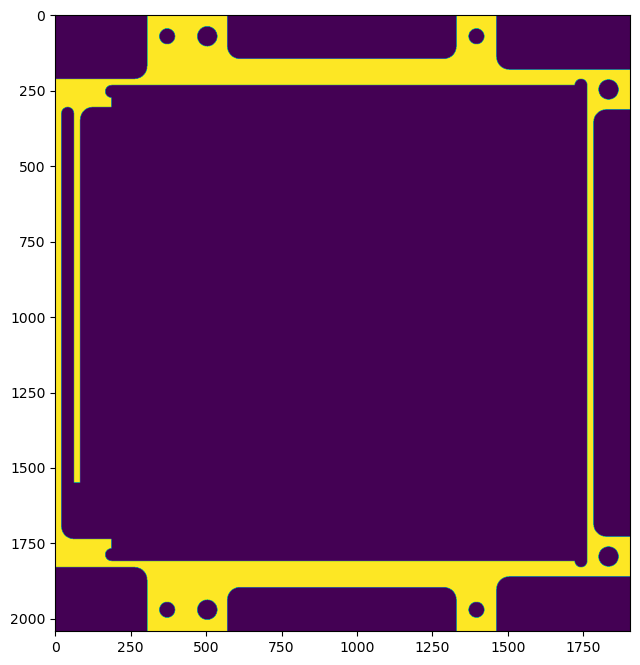

In [30]:
# stl_file = f"/{loc}/jpbreuer/Scripts/geant4_grbalpha/camelot/1U_skelton_onlyframe_ascii.stl"
# stl_file = f"/{loc}/jpbreuer/Scripts/geant4_grbalpha/camelot/base_v3_ascii.stl"
# stl_file = f"/{loc}/jpbreuer/Scripts/geant4_grbalpha/camelot/pb_cover_full_ascii.stl"
# stl_file = f"/{loc}/jpbreuer/Scripts/geant4_grbalpha/camelot/top_v2_stp1_01_ascii.stl"
stl_file = f"/{loc}/jpbreuer/geant4/cad_files/masoto/base_v3_masa1_ascii.stl"

resolution=2042
voxel_size=None
parallel=False

new_obj = Convert_STL_to_voxels(stl_file=stl_file, resolution=resolution, voxel_size=voxel_size, parallel=parallel)
vox, scale, shift, dim_cm, vox_cm, dim_mm, vox_mm = new_obj.convert_file()


fig = plt.figure(figsize=(16, 8))
plt.imshow(vox[:,:,0])
# plt.imshow(vox[1])
# plt.imshow(vox[2])
# plt.imshow(vox[3])
# plt.imshow(vox[resolution//2])
# plt.imshow(vox[resolution-1])
# plt.imshow(vox[7])
# plt.imshow(vox[15])
# plt.imshow(vox[7])

In [ ]:
def voxel_array_to_bricks(vox):
	"""
	Convert a dense boolean/0-1 voxel grid into a list of maximal
	axis-aligned bricks  (x0,x1,y0,y1,z0,z1)  with inclusive bounds.
	Returns
		bricks  : list[tuple]   6-tuples in index space (no scaling yet)
	"""
	filled   = vox.astype(bool)
	visited  = np.zeros_like(filled, dtype=bool)
	Z,Y,X    = vox.shape
	bricks   = []

	for z in range(Z):
		for y in range(Y):
			x = 0
			while x < X:
				if filled[z,y,x] and not visited[z,y,x]:

					# ---------- grow along +x ----------
					x1 = x
					while x1+1 < X and filled[z,y,x1+1] and not visited[z,y,x1+1]:
						x1 += 1

					# ---------- grow along +y ----------
					y1 = y
					grow_y = True
					while grow_y and y1+1 < Y:
						for xx in range(x, x1+1):
							if not (filled[z,y1+1,xx] and not visited[z,y1+1,xx]):
								grow_y = False; break
						if grow_y: y1 += 1

					# ---------- grow along +z ----------
					z1 = z
					grow_z = True
					while grow_z and z1+1 < Z:
						for yy in range(y, y1+1):
							for xx in range(x, x1+1):
								if not (filled[z1+1,yy,xx] and not visited[z1+1,yy,xx]):
									grow_z = False; break
							if not grow_z: break
						if grow_z: z1 += 1

					# ---------- mark & save ----------
					visited[z:z1+1, y:y1+1, x:x1+1] = True
					bricks.append((x, x1, y, y1, z, z1))

					x = x1 + 1        # skip ahead
				else:
					x += 1
	return bricks

def write_bricks_to_geo(bricks, voxel_size, shift, material="Aluminium", mother="WorldVolume", outfile="output.geo", log_every=10000):
	"""
	bricks  : list produced by voxel_array_to_bricks
	voxel_size : (sx, sy, sz) in mm (or whatever MEGAlib expects)
	shift   : shift that was applied during voxelisation (same units)
	"""
	def rand_id(n=6):                     # nice readable IDs if wanted
		return ''.join(random.choice(string.ascii_uppercase+string.digits) for _ in range(n))
	
	sx, sy, sz = voxel_size
	lines = []
	introline = "Include $(MEGALIB)/resource/examples/geomega/materials/Materials.geo\n\nVolume WorldVolume\nWorldVolume.Material Vacuum\nWorldVolume.Visibility 0\nWorldVolume.Shape BRIK 5000. 5000. 5000.\nWorldVolume.Mother 0\n\n"
	for n,(x0,x1,y0,y1,z0,z1) in enumerate(bricks):
		# physical half-dimensions (BRIK wants half-lengths)
		dx = (x1 - x0 + 1) * sx / 2.0
		dy = (y1 - y0 + 1) * sy / 2.0
		dz = (z1 - z0 + 1) * sz / 2.0
 
		# centre in world coordinates
		cx = (shift[0]/10) + (x0 + x1 + 1)*sx/2.0
		cy = (shift[1]/10) + (y0 + y1 + 1)*sy/2.0
		cz = (shift[2]/10) + (z0 + z1 + 1)*sz/2.0
 
		name = f"B{n}_{rand_id(n=5)}"
		oref = f"{name}Orientation"
		cube_string = (
			f"Volume {name}\n"
			f"{name}.Shape BRIK {dx:.3f} {dy:.3f} {dz:.3f}\n"
			f"{name}.Material {material}\n"
			f"{name}.Position {cx:.3f} {cy:.3f} {cz:.3f}\n"
			f"{name}.Rotation 0 0 0\n"
			f"{name}.Visibility 1\n"
			f"{name}.Color 12\n"
			f"{name}.Mother {mother}\n\n")
		lines.append(cube_string)
 
		if (n+1) % log_every == 0:
			print(f"-- wrote {n+1}/{len(bricks)} bricks")
 
	with open(outfile,"w") as fp:
		fp.write(introline)
		fp.writelines(lines)
	print(f"Finished: {len(bricks)} bricks → {outfile}")

In [31]:
bricks = voxel_array_to_bricks(vox)
write_bricks_to_geo(bricks,
                    voxel_size=vox_cm,          # mm or cm as you prefer
                    shift=shift,                 # same shift you used earlier
                    outfile="model_bricked.geo")

Finished: 2829 bricks → model_bricked.geo
